In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import scipy as sp
# import sklearn
import time

from statsmodels.nonparametric import kernel_regression # Local linear smoothing
import shap
import sage

# 1 Simulated Data

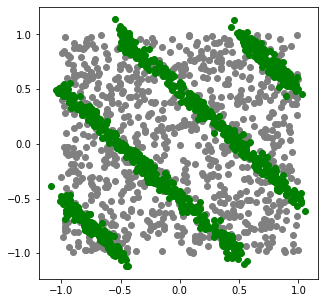

In [2]:
# Generate data

# Class 1: Grey
X1grey = np.random.uniform(-1, 1, 900)
X2grey = np.random.uniform(-1, 1, 900)

# Class 2: Green
X1green1 = np.random.uniform(-1, -0.5, 150) + np.random.normal(0, 0.05, 150)
X2green1 = -1.5 - X1green1 + np.random.normal(0, 0.05, 150)

X1green2 = np.random.uniform(-1, 0.5, 300) + np.random.normal(0, 0.05, 300)
X2green2 = -0.5 - X1green2 + np.random.normal(0, 0.05, 300)

X1green3 = np.random.uniform(-0.5, 1, 300) + np.random.normal(0, 0.05, 300)
X2green3 = 0.5 - X1green3 + np.random.normal(0, 0.05, 300)

X1green4 = np.random.uniform(0.5, 1, 150) + np.random.normal(0, 0.05, 150)
X2green4 = 1.5 - X1green4 + np.random.normal(0, 0.05, 150)
# plt.scatter(X1green4, X2green4, color = "green")

X1green = np.concatenate((X1green1, X1green2, X1green3, X1green4))
X2green = np.concatenate((X2green1, X2green2, X2green3, X2green4))

fig_dat, ax_dat = plt.subplots(figsize = (5,5))
# figure(figsize=(2, 2), layout='constrained')
ax_dat.scatter(X1grey, X2grey, color = "grey")
ax_dat.scatter(X1green, X2green, color = "green")
# plt.show()

In [3]:
X1 = np.concatenate((X1grey, X1green))
X2 = np.concatenate((X2grey, X2green))

X = np.array([X1,X2]).T
Y = [0]*len(X1grey) + [1]*len(X1green)

print("Dimentionality of X: ", X.shape)
print("X: \n", X)

Dimentionality of X:  (1800, 2)
X: 
 [[-0.82087706  0.29523965]
 [ 0.98919288  0.99867433]
 [-0.40199518  0.61210672]
 ...
 [ 0.87156034  0.69379041]
 [ 0.89270618  0.43672857]
 [ 0.85964525  0.6083618 ]]


In [10]:
def scale(x, colmean, axis = 0):
    """
    Scale the data in each feature.
    --------------------
    Parameters:
    - x: Array-like. Original data with each observation stored in a row and each featue is recorded in a column.
    - colmean: Array-like. The mean of each column.
    - axis: 0 or 1. Direction to scale x along. '0' for the mean of each column; 1' for the mean of each row.
    """
    y = (x - colmean) / np.std(x, axis=0)
    return y

# 2 Model Fitting

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

In [5]:
# Model Fitting

LR = LogisticRegression(penalty="l2")
LR.fit(X, Y)

# LR.score(X, Y)   # accuracy

print("The classes of the LR model output: ", LR.classes_)
print("Prediction class probabilities for each input: ")
print(LR.predict_proba(X))   # prediction class probabilities for each input ((N, k): N datapoints, k classes)
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression.predict_proba

probs = LR.predict_proba(X)[:,1]    # prediction probability of class 1 for each input
probs

The classes of the LR model output:  [0 1]
Prediction class probabilities for each input: 
[[0.51886488 0.48113512]
 [0.48456316 0.51543684]
 [0.51184194 0.48815806]
 ...
 [0.48525936 0.51474064]
 [0.48329101 0.51670899]
 [0.48500746 0.51499254]]


array([0.48113512, 0.51543684, 0.48815806, ..., 0.51474064, 0.51670899,
       0.51499254])

In [7]:
# Random Forest:
RF = RandomForestClassifier().fit(X,Y)
print("Prediction: ", RF.predict(X))
probs_class1 = RF.predict_proba(X)[:,1]
print("Class 1 probability: ", probs_class1)

Prediction:  [0 0 0 ... 1 1 1]
Class 1 probability:  [0.33 0.24 0.02 ... 0.97 0.64 1.  ]


In [6]:
# Neual Network:
MLP = MLPClassifier().fit(X,Y)
print("Prediction: ", MLP.predict(X))
probs_class1 = MLP.predict_proba(X)[:,1]
print("Class 1 probability: ", probs_class1)

Prediction:  [0 1 0 ... 1 1 1]
Class 1 probability:  [0.45879535 0.71228866 0.3804914  ... 0.67509764 0.59743901 0.65348217]


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


# 3 Interpretability Methods

In [11]:
# a function for all #
######################

class Interpret:
    """
    A comparison of interpretability methods including Active Subspace, SHAP and SAGE 
    for a binary classification model trained on two-dimentional data.
    ------------------------------
    Necessary packages or functions:
    - statsmodels.nonparametric.kernel_regression
    - shap
    - sage
    ------------------------------
    Parameters: 
    model: the trained classifier
    X: 2D-array. Training data
    Y: 1D-array. Corresponding prediction of training data
    ------------------------------
    """
    
    def __init__(self, model, X, Y):
        self.model = model
        self.X = X
        self.Y = Y
        
        self.model_info()
        
        # Store the interpreter objects
        #self.AS_PCA = None
        self.active_subspace()
        
        #self.SHAP = 
        self.shap()
        
        #self.SAGE =
        #self.sage()
      
    # Simple functions to call to understand the model prediction
    def model_info(self):
        print("Classifier: ", self.model)
        print("Classes: ", self.model.classes_)
        print("Class probabilities:", self.model.predict_proba(self.X[:1]))
    
    @staticmethod
    def scale(x, colmean, axis = 0):
        """
        Scale the data in each feature.
        --------------------
        Parameters:
        - x: Array-like. Original data with each observation stored in a row and each featue is recorded in a column.
        - colmean: Array-like. The mean of each column.
        - axis: 0 or 1. Direction to scale x along. '0' for the mean of each column; 1' for the mean of each row.
        """
        y = (x - colmean) / np.std(x, axis=0)
        return y
    
    # Interpretability Methods:
    def active_subspace(self):
        print("""-----------------------------\nInterpreting with Active Subspace...\n""")
        
        proba = self.model.predict_proba(X)[:,1]    # prediction probability of class 1 for each input
        kreg = kernel_regression.KernelReg(endog = probs, exog = [X[:,0], X[:,1]], var_type = "cc") 
        grad = kreg.fit()[1]   # marginal effect; local gradients
        print("Local gradients of each observation: \n", grad)
        scaled_grad = scale(grad, np.mean(grad, axis=0))
        print("Conduct PCA over the scaled local gradients")
        pca = PCA(n_components = 2)
        self.AS_PCA = pca.fit(scaled_grad)
        pca_fit = pca.fit(scaled_grad)
        print("The variance raio explained by PCA: ", pca_fit.explained_variance_ratio_)
        print("PCs: ", pca_fit.components_)
        
        return pca_fit
    
    
    def shap(self):
        print("""-----------------------------\nInterpreting with SHAP...\n""")
        
        interpretSHAP = shap.Explainer(self.model, X)
        shap_values = interpretSHAP(X).values
        print("SHAP values: \n", shap_values)
        
        return shap_values
        
        
# #     def sage(self):
        
     
    # Plot the variable after using each method
    def plot(self):
        fig, ax = plt.subplots(3, 1, sharex=True, sharey=True)
        
        
        # AS_PCA = self.active_subspace()
        
        # Plot the first Principle Component
        pc = self.AS_PCA.components_[0]   # 1st PC
        print(pc)
        plt.barh(['X1','X2'], pc)
        
        # Plot the SHAP values
        # SHAP = self.shap()
        # 1. Violin plot
        # 2. Barplot
        
        
        # Plot the SAGE values
#         SAGE = self.sage()
        

In [12]:
# TEST: Interpret Class
# --------------------------------------

a = Interpret(model = RF, X=X, Y=Y)
a.model_info()

Classifier:  RandomForestClassifier()
Classes:  [0 1]
Class probabilities: [[0.67 0.33]]
-----------------------------
Interpreting with Active Subspace...

Local gradients of each observation: 
 [[ 0.02122683 -0.00590737]
 [ 0.02123564 -0.00590966]
 [ 0.02124506 -0.00591251]
 ...
 [ 0.02123844 -0.00591092]
 [ 0.02123382 -0.00590961]
 [ 0.02123841 -0.00591078]]
Conduct PCA over the scaled local gradients
The variance raio explained by PCA:  [9.99316827e-01 6.83172569e-04]
PCs:  [[-0.70710678  0.70710678]
 [ 0.70710678  0.70710678]]
-----------------------------
Interpreting with SHAP...



 99%|===================| 3560/3600 [01:31<00:01]        

SHAP values: 
 [[[ 0.0349     -0.0349    ]
  [ 0.0448     -0.0448    ]]

 [[ 0.1748     -0.1748    ]
  [-0.0051      0.0051    ]]

 [[ 0.2157     -0.2157    ]
  [ 0.174      -0.174     ]]

 ...

 [[-0.28299999  0.28299999]
  [-0.27729999  0.27729999]]

 [[-0.1695      0.1695    ]
  [-0.0608      0.0608    ]]

 [[-0.32154999  0.32154999]
  [-0.26874999  0.26874999]]]
Classifier:  RandomForestClassifier()
Classes:  [0 1]
Class probabilities: [[0.67 0.33]]


[-0.70710678  0.70710678]


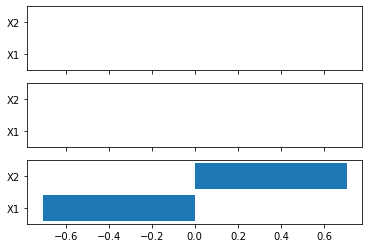

In [13]:
a.plot()